# Cognitive Age Prediction with MEG

In [1]:
import mne
import numpy as np
import pandas as pd

from camcan.utils import (plot_pred, plot_learning_curve,
                          plot_barchart, run_ridge,
                          plot_error_age, plot_error_segments,
                          plot_boxplot)

%matplotlib inline

/home/okozynet/projects/scikit-learn/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/okozynet/miniconda3/envs/mne/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate bin

In [2]:
CV = 10
# store mae, std for the summary plot
meg_mae = {}
meg_mae_std = {}
meg_pred_diff = {}

## Read Data

In [3]:
subjects_data = pd.read_csv('../../data/participant_data.csv', index_col=0)
subjects_predictions = pd.DataFrame(subjects_data.age, index=subjects_data.index, dtype=float)
subjects_data.head()

,age,hand,gender_text,gender_code,tiv_cubicmm,cbuid700,cbuid280_sess1,cbuid280_sess2,cbuid280_sess3,cbuid280_sess4,profilecode,profilecode_numeric
Observations,,,,,,,,,,,,
CC110033,24,90.0,MALE,1,1413746.0,CBU120746,NaN,NaN,NaN,NaN,NaN,NaN
CC110037,18,89.0,MALE,1,1386581.0,CBU110544,NaN,NaN,NaN,NaN,NaN,NaN
CC110045,24,100.0,FEMALE,2,1385355.0,CBU111116,NaN,NaN,NaN,NaN,NaN,NaN
CC110056,22,100.0,FEMALE,2,1286849.0,CBU110547,NaN,CBU140153,CBU140224,NaN,D,1.0
CC110062,20,58.0,MALE,1,1582719.0,CBU110468,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
FREQ_BANDS = ('alpha',
              'beta_high',
              'beta_low',
              'delta',
              'gamma_high',
              'gamma_lo',
              'gamma_mid',
              'low',
              'theta')

In [6]:
MEG_SOURCE_SPACE_DATA = '../../data/meg_source_space_data.h5'

meg_data = pd.read_hdf(MEG_SOURCE_SPACE_DATA, key='meg')

columns_to_exclude = ('band', 'fmax', 'fmin', 'subject')
parcellation_labels = [c for c in meg_data.columns if c
                       not in columns_to_exclude]
band_data = [meg_data[meg_data.band == bb].set_index('subject')[
                parcellation_labels] for bb in FREQ_BANDS]
meg_data = pd.concat(band_data, axis=1, join='inner', sort=False)

print(f'Found {len(meg_data)} subjects')

Found 595 subjects


## The Brain Age Prediction using MEG data in Source Space

MAE: 8.22
MAE STD: 2.31


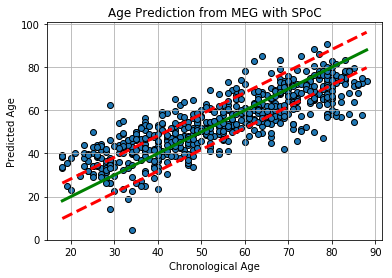

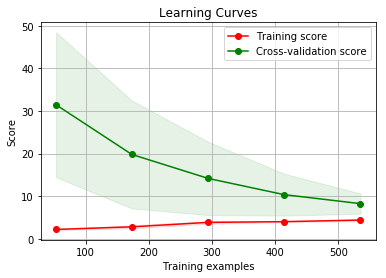

In [9]:
df_pred, arr_mae, arr_r2, train_sizes, train_scores, test_scores = \
    run_ridge(meg_data, subjects_data, alphas=np.logspace(-3, 5, 100), cv=CV)

arr_mae = -arr_mae
mae = arr_mae.mean()
std = arr_mae.std()

print('MAE: %.2f' % mae)
print('MAE STD: %.2f' % std)

meg_mae['MEG'] = arr_mae
meg_mae_std['MEG'] = (mae, std)
subjects_predictions.loc[df_pred.index, 'MEG'] = df_pred['y']

plot_pred(subjects_predictions.loc[df_pred.index].age,
          subjects_predictions.loc[df_pred.index, 'MEG'],
          mae, title='Age Prediction from MEG with SPoC')
plot_learning_curve(train_sizes, train_scores, test_scores)

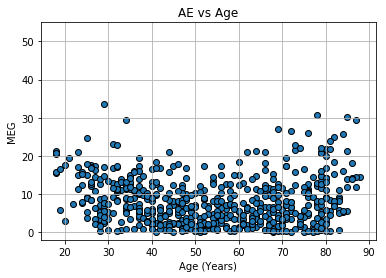

In [10]:
plot_error_age(subjects_predictions, ylim=(-2, 55))

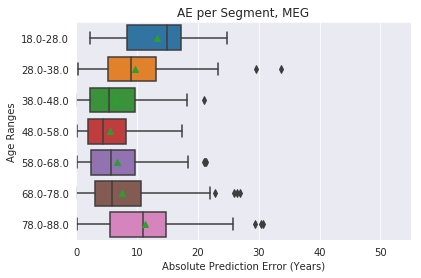

In [11]:
plot_error_segments(subjects_predictions, segment_len=10)

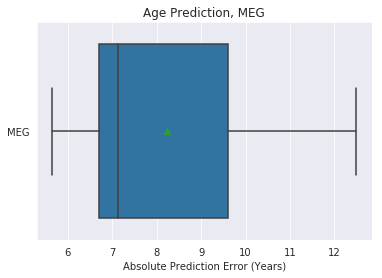

In [12]:
plot_boxplot(meg_mae, title='Age Prediction, MEG')